In [1]:
import cv2
cv2.__version__


'3.3.0-dev'

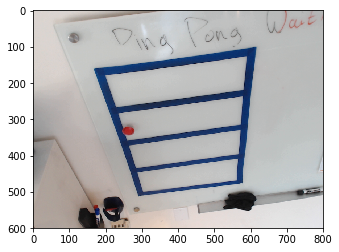

In [214]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
img = cv2.imread("stills-thu/frame1982.png")
# test plotting
def imshow(img):  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
imshow(img)

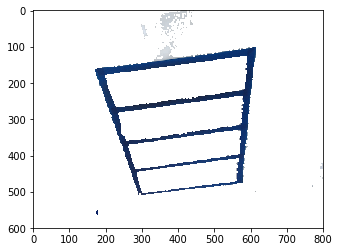

In [238]:
# DEGBUG step 1, extract the right kind of blue
image = img
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
threshold  = np.array([[100,0,0],[115,255,255]])
mask = cv2.inRange(hsv, threshold[0,:], threshold[1,:])
mask = cv2.erode(mask, np.ones((5,5), np.uint8))
masked = cv2.bitwise_and(hsv, hsv, mask=mask)
blue = cv2.cvtColor(masked, cv2.COLOR_HSV2BGR)
del  masked
bluewhite = cv2.bitwise_or(blue, cv2.bitwise_not(np.stack(3* [mask], axis=2)))
imshow(bluewhite)

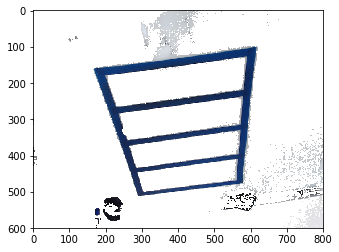

In [215]:
# step 1, extract the right kind of blue
image = img
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
threshold  = np.array([[100,0,0],[140,255,255]])
mask = cv2.inRange(hsv, threshold[0,:], threshold[1,:])
masked = cv2.bitwise_and(hsv, hsv, mask=mask)
blue = cv2.cvtColor(masked, cv2.COLOR_HSV2BGR)
del  masked
bluewhite = cv2.bitwise_or(blue, cv2.bitwise_not(np.stack(3* [mask], axis=2)))
imshow(bluewhite)

10


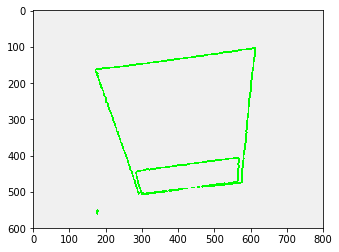

In [239]:
# extract raw contours
dst = np.zeros(image.shape, np.uint8)
dst[:]=(240,240,240)

img = cv2.cvtColor(bluewhite, cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img, (3,3), 0)
img = cv2.threshold(img, 60, 255, cv2.THRESH_BINARY)[1]
img = cv2.bitwise_not(img)  # contours expects white image on black bg

cnts = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
print(len(cnts))
cv2.drawContours(dst, cnts, -1, (0,255,0), 3)
plt.imshow(dst)

In [240]:
# simplify contours, find one that is a rectangle
dst[:] = (255,240,240)
for c in cnts:
    peri = 0.01 * cv2.arcLength(c, True)  # approximate such that new perimeter is 1% of old one
    approx = cv2.approxPolyDP(c, peri, True)
    if len(approx) == 4:
            approx = np.reshape(approx,[4,2]) # drop 2nd dimension 
            xsize = approx[:,0].max() - approx[:,0].min()
            ysize = approx[:,1].max() - approx[:,1].min()
            if xsize > 300 and ysize > 150:
                print ("FOUND", approx)
                cv2.drawContours(dst, [approx], -1, (0,255,0), 2)
                break
    else:
        raise ValueError("No outer rectangle found")
            
imshow(dst)

ValueError: No outer rectangle found

In [8]:
# apply perspective transform
# http://www.pyimagesearch.com/2014/05/05/building-pokedex-python-opencv-perspective-warping-step-5-6/
#approx
#dst = np.array([[0,0],[799,0],[799,599],[0,599]], dtype = "float32")
#M = cv2.getPerspectiveTransform(approx, dst)
#warp = cv2.warpPerspective(img, M, (800, 600))

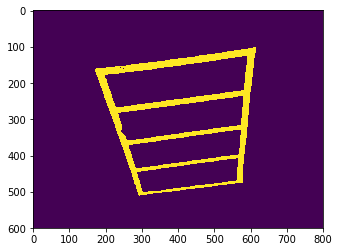

In [153]:
# mask area outside outer rectangle on b/w image for contour finding
mask = np.zeros(image.shape[:2], np.uint8)
cv2.drawContours(mask, [approx], -1, 255, cv2.FILLED)
img2 = cv2.bitwise_and(img, mask)
plt.imshow(img2)

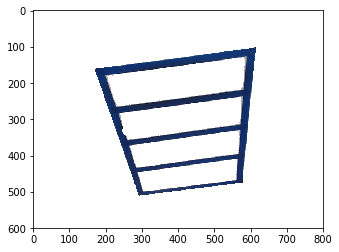

In [13]:
# mask blue white image
##mask = np.zeros(image.shape[:2], np.uint8)
#cv2.drawContours(mask, [approx], -1, (255), cv2.FILLED)
#bluewhite2 = cv2.bitwise_or(bluewhite, cv2.bitwise_not(np.stack(3* [mask], axis=2)))
#imshow(bluewhite2)



In [174]:
# find inner rectangles
_, cnts, hier = cv2.findContours(img2.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = []
for i in range(len(cnts)):
    contour = cnts[i]
    _,_,w,h = cv2.boundingRect(contour)
    if w>100 and h>50:
        contours.append(contour)
    else:
        hier[0, i, :] = -2 # mark for deletion
        
hier = np.delete(hier, np.where(hier[0,:,-1] == -2)[0], 1)

assert len(contours) == 5, "there are five contours"
assert hier[0,0,-1] == -1, "first contour is the outer one, ie it has no parent"
assert np.all(hier[0,1:5,-1] == 0), "all other contours have the first contour as their parent"
hier = np.delete(hier, 0, 1) # remove parent from list of hier
contours = contours[1:] # remove parent from contours
contours.sort(key=lambda a: a[:,0,1].min()) # sort contours by minimum y value (top down)

In [175]:
# determine size of largest (topmost) bounding box
_,_,bbw,bbh = cv2.boundingRect(contours[0])

In [176]:
# for each inner box, add white mask and crop to a standard size box
boxes = []
kernel =  np.ones((5,5), np.uint8)
for contour in contours:
    # compute mask from contour by filling
    mask = np.zeros(image.shape[:2], np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
    # make mask about 5px smaller on all sides
    mask = cv2.erode(mask, kernel)
    # create white box and copy image in where mask is true
    box = np.zeros_like(image)
    box.fill(255)
    box[mask == 255] = image[mask == 255] 
    # crop to bounding box
    bbx, bby, w, h = cv2.boundingRect(contour)
    assert bbw >= w and bbh >= h, "all boxes are smaller than the top one"
    box = box[bby:(bby+bbh), bbx:(bbx+bbw), :]
    boxes.append(box)
    

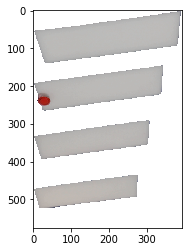

In [177]:
#imshow(boxes[3])
imshow(np.concatenate(boxes))